In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0
torch:  2.3 ; cuda:  2.3.1
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "E:\\Random Python Scripts\\FarmLand-Segmentation-main\\Detectron 2\\Dataset.v1i.coco-segmentation\\train\\_annotations.coco.json", 'E:\\Random Python Scripts\\FarmLand-Segmentation-main\\Detectron 2\\Dataset.v1i.coco-segmentation\\train')
register_coco_instances("my_dataset_val", {}, "E:\\Random Python Scripts\\FarmLand-Segmentation-main\\Detectron 2\\Dataset.v1i.coco-segmentation\\valid\\_annotations.coco.json", "E:\\Random Python Scripts\\FarmLand-Segmentation-main\\Detectron 2\\Dataset.v1i.coco-segmentation\\valid")

In [5]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

WARNING [07/03 12:28:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/03 12:28:53 d2.data.datasets.coco]: Loaded 462 images in COCO format from E:\Random Python Scripts\FarmLand-Segmentation-main\Detectron 2\Dataset.v1i.coco-segmentation\train\_annotations.coco.json


In [6]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")


WARNING [07/03 12:28:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/03 12:28:53 d2.data.datasets.coco]: Loaded 44 images in COCO format from E:\Random Python Scripts\FarmLand-Segmentation-main\Detectron 2\Dataset.v1i.coco-segmentation\valid\_annotations.coco.json


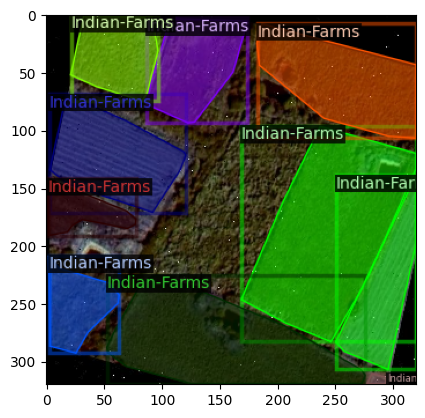

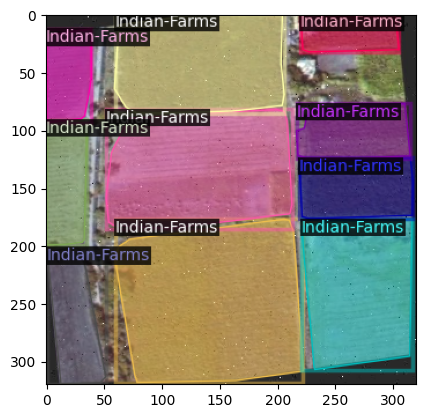

In [7]:
from matplotlib import pyplot as plt

# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [16]:

from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "E:\Random Python Scripts\FarmLand-Segmentation-main\Detectron 2\Model 1"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[07/03 12:31:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

In [17]:
trainer.train()

[07/03 12:32:00 d2.engine.train_loop]: Starting training from iteration 0
[07/03 12:32:09 d2.utils.events]:  eta: 0:05:14  iter: 19  total_loss: 3.696  loss_cls: 1.577  loss_box_reg: 0.8539  loss_mask: 0.692  loss_rpn_cls: 0.458  loss_rpn_loc: 0.07363    time: 0.3197  last_time: 0.3096  data_time: 0.1286  last_data_time: 0.0021   lr: 4.9953e-06  max_mem: 2960M
[07/03 12:32:15 d2.utils.events]:  eta: 0:05:03  iter: 39  total_loss: 3.469  loss_cls: 1.474  loss_box_reg: 0.8325  loss_mask: 0.6861  loss_rpn_cls: 0.339  loss_rpn_loc: 0.06996    time: 0.3172  last_time: 0.3165  data_time: 0.0040  last_data_time: 0.0069   lr: 9.9902e-06  max_mem: 2960M
[07/03 12:32:22 d2.utils.events]:  eta: 0:04:57  iter: 59  total_loss: 3.123  loss_cls: 1.287  loss_box_reg: 0.8682  loss_mask: 0.6726  loss_rpn_cls: 0.2907  loss_rpn_loc: 0.07294    time: 0.3164  last_time: 0.3034  data_time: 0.0050  last_data_time: 0.0058   lr: 1.4985e-05  max_mem: 2960M
[07/03 12:32:28 d2.utils.events]:  eta: 0:04:52  iter: 7

In [19]:
import yaml
config_yaml_path = "E:\Random Python Scripts\FarmLand-Segmentation-main\Detectron 2\Model 1\config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[07/03 12:38:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from E:\Random Python Scripts\FarmLand-Segmentation-main\Detectron 2\Model 1\model_final.pth ...


In [25]:
import cv2
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imshow("Prediction", out.get_image()[:, :, ::-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [26]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [07/03 12:44:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/03 12:44:42 d2.data.datasets.coco]: Loaded 44 images in COCO format from E:\Random Python Scripts\FarmLand-Segmentation-main\Detectron 2\Dataset.v1i.coco-segmentation\valid\_annotations.coco.json
[07/03 12:44:42 d2.data.build]: Distribution of instances among all 2 categories:
|   category   | #instances   |   category   | #instances   |
|:------------:|:-------------|:------------:|:-------------|
| Indian-Farms | 0            | Indian-Farms | 379          |
|              |              |              |              |
|    total     | 379          |              |              |
[07/03 12:44:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/03 12:44:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.com

In [33]:
new_im = cv2.imread(r"E:\Random Python Scripts\FarmLand-Segmentation-main\Detectron 2\Dataset.v1i.coco-segmentation\test\tile_2_10_png.rf.aaf7d4e7b10efd3ee67430494e3117fc.jpg")

# Make predictions using the predictor
outputs = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the image
cv2.imshow("Prediction", out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [37]:
# Set the directory path
dir_path = r"E:\Random Python Scripts\FarmLand-Segmentation-main\Detectron 2\Dataset.v1i.coco-segmentation\test"

# Get a list of all .jpg files in the directory
jpg_files = [f for f in os.listdir(dir_path) if f.endswith(".jpg")]

# Randomly select a file from the list
random_file = random.choice(jpg_files)

# Construct the full file path
file_path = os.path.join(dir_path, random_file)

# Load the image
new_im = cv2.imread(file_path)

# Make predictions using the predictor
outputs = predictor(new_im)

# Use Visualizer to draw the predictions on the image
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the image
cv2.imshow("Prediction", out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()